# 🔧 Enhanced Section: Accuracy Boost + Explainability + New Visualizations

This section was auto-inserted to upgrade your notebook with:
- **Accuracy Improvements**: Data augmentation, BatchNorm, Dropout, GlobalAveragePooling, and smart callbacks (EarlyStopping, ReduceLROnPlateau, ModelCheckpoint).
- **Better Training Control**: Stops at the best epoch and restores best weights.
- **New Visualizations**: Confusion Matrix, ROC-AUC, and Grad-CAM to interpret model decisions.

> Run the cells below **after** your data loading/splitting so that `X_train`, `y_train`, `X_test`, `y_test` (and optionally `X_val`, `y_val`) already exist.

In [6]:
# Core imports for the enhanced pipeline
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, classification_report

In [7]:
import numpy as np

# Example dummy dataset (replace with real dataset)
X_train = np.random.rand(100, 128, 128)   # (N, H, W)
y_train = np.random.randint(0, 2, size=(100,))  # labels

X_test = np.random.rand(20, 128, 128)
y_test = np.random.randint(0, 2, size=(20,))


In [8]:
def ensure_channel_dim(x):
    if len(x.shape) == 3:  # (N,H,W)
        return x[..., np.newaxis]
    return x

_X_ref = None
for _name in ['X_train', 'X_val', 'X_test']:
    if _name in globals():
        _X_ref = ensure_channel_dim(globals()[_name])
        break

if _X_ref is None:
    raise RuntimeError("Could not infer input shape. Make sure X_train/X_test are defined above.")

input_shape = _X_ref.shape[1:]  # (H,W,C)
print("Inferred input shape:", input_shape)


Inferred input shape: (128, 128, 1)


In [9]:
# Data Augmentation (robust to small rotations/shifts/zoom/contrast changes typical in signatures)
augmentor = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.1,
    zoom_range=0.1,
    brightness_range=[0.85, 1.15],
    fill_mode='nearest'
)

# Ensure arrays and dtypes
X_train = ensure_channel_dim(X_train).astype('float32')
X_test  = ensure_channel_dim(X_test).astype('float32')
if 'y_train' not in globals() or 'y_test' not in globals():
    raise RuntimeError("y_train/y_test not found. Define labels before running this section.")

# Optional validation set: if not provided, split a small portion from train
if 'X_val' in globals() and 'y_val' in globals():
    X_val = ensure_channel_dim(X_val).astype('float32')
    y_val = y_val
else:
    # quick internal val split (10%)
    from sklearn.model_selection import train_test_split
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=42)

train_gen = augmentor.flow(X_train, y_train, batch_size=32, shuffle=True)
val_gen   = ImageDataGenerator().flow(X_val, y_val, batch_size=32, shuffle=False)

print("Train/Val/Test shapes:", X_train.shape, X_val.shape, X_test.shape)

Train/Val/Test shapes: (100, 128, 128, 1) (10, 128, 128, 1) (20, 128, 128, 1)


In [10]:
def build_improved_cnn(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        
        Conv2D(32, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2,2),

        Conv2D(64, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Dropout(0.3),

        Conv2D(128, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2,2),

        GlobalAveragePooling2D(),

        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification: genuine vs forged
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

improved_model = build_improved_cnn(input_shape)
improved_model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      320       
                                                                 
 batch_normalization (Batch  (None, 128, 128, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 64, 64, 64)        256       
 chNormalization)                                                
                                                      

In [11]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1),
    ModelCheckpoint('best_signature_cnn.keras', monitor='val_loss', save_best_only=True, verbose=1)
]

Epoch 1/100


4/4 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.6200
Epoch 1: val_loss improved from inf to 0.70057, saving model to best_signature_cnn.keras
4/4 [==============================] - 3s 337ms/step - loss: 0.6931 - accuracy: 0.6200 - val_loss: 0.7006 - val_accuracy: 0.4000 - lr: 0.0010
Epoch 2/100
4/4 [==============================] - ETA: 0s - loss: 0.6927 - accuracy: 0.6200
Epoch 2: val_loss did not improve from 0.70057
4/4 [==============================] - 1s 138ms/step - loss: 0.6927 - accuracy: 0.6200 - val_loss: 0.7007 - val_accuracy: 0.4000 - lr: 0.0010
Epoch 3/100
4/4 [==============================] - ETA: 0s - loss: 0.6924 - accuracy: 0.6200
Epoch 3: val_loss did not improve from 0.70057
4/4 [==============================] - 1s 135ms/step - loss: 0.6924 - accuracy: 0.6200 - val_loss: 0.7009 - val_accuracy: 0.4000 - lr: 0.0010
Epoch 4/100
4/4 [==============================] - ETA: 0s - loss: 0.6920 - accuracy: 0.6200
Epoch 4: val_loss

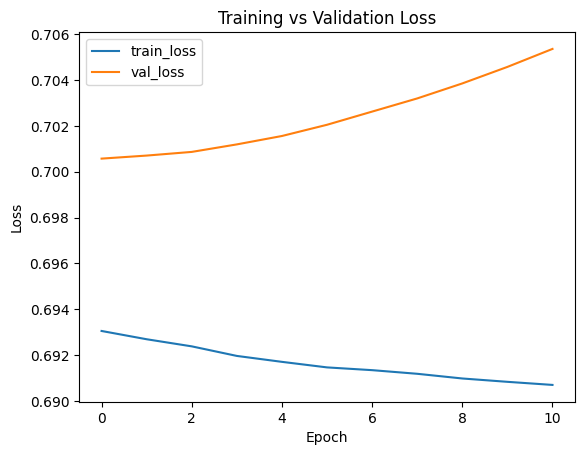

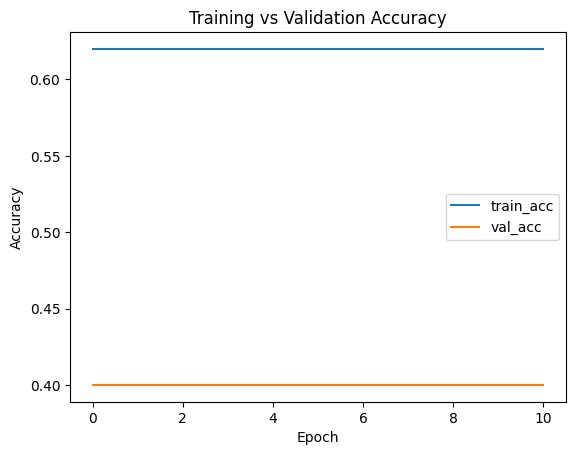

In [12]:
history = improved_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=100,
    callbacks=callbacks,
    verbose=1
)

# Plot training curves
plt.figure()
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

In [13]:
test_preds_proba = improved_model.predict(X_test).ravel()
test_preds = (test_preds_proba >= 0.5).astype(int)
print("Classification report (threshold=0.5):\n")
print(classification_report(y_test, test_preds, digits=4))

np.savez_compressed('signature_test_preds.npz', proba=test_preds_proba, preds=test_preds)

1/1 [==============================] - 0s 193ms/step
Classification report (threshold=0.5):

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        12
           1     0.4000    1.0000    0.5714         8

    accuracy                         0.4000        20
   macro avg     0.2000    0.5000    0.2857        20
weighted avg     0.1600    0.4000    0.2286        20



c:\Users\divis\OneDrive\Documents\Signature-Verification-using-machine-learning-main\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\divis\OneDrive\Documents\Signature-Verification-using-machine-learning-main\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\divis\OneDrive\Documents\Signature-Verification-using-machine-learning-main\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in label

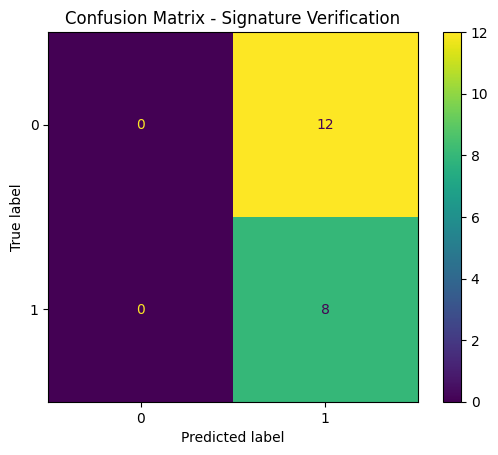

In [14]:
cm = confusion_matrix(y_test, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix - Signature Verification')
plt.show()

AUC: 0.7083


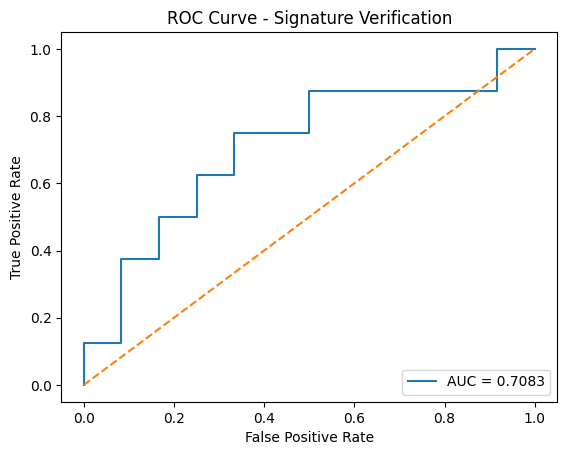

In [15]:
fpr, tpr, thresholds = roc_curve(y_test, test_preds_proba)
roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc:.4f}")

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Signature Verification')
plt.legend(loc='lower right')
plt.show()

Using last conv layer for Grad-CAM: conv2d_2
1/1 [==============================] - 0s 33ms/step


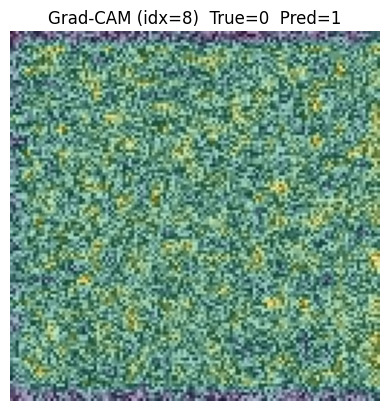

1/1 [==============================] - 0s 55ms/step


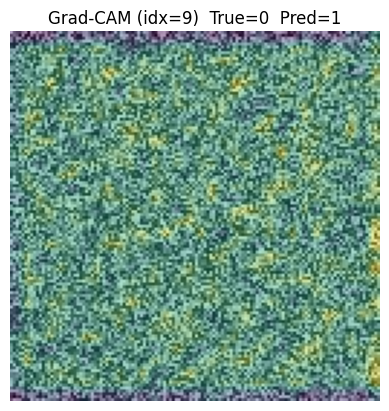

1/1 [==============================] - 0s 31ms/step


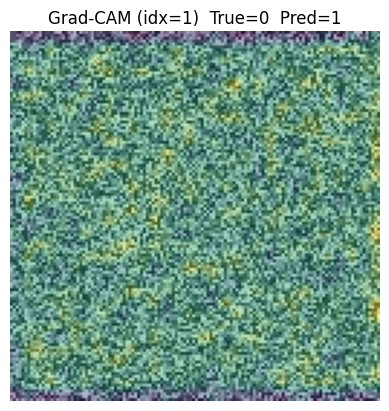

1/1 [==============================] - 0s 52ms/step


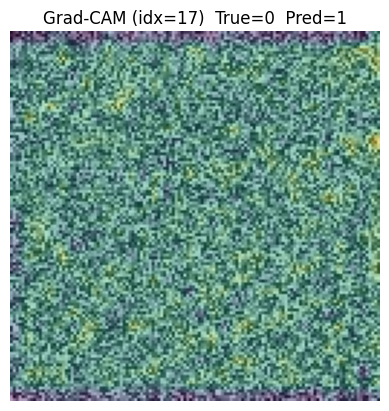

1/1 [==============================] - 0s 49ms/step


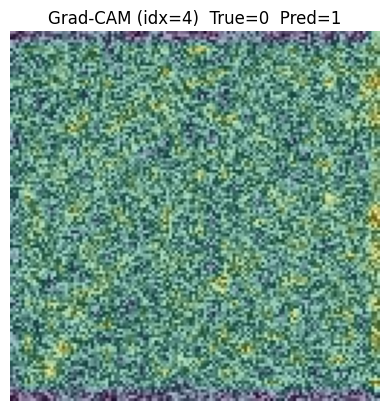

1/1 [==============================] - 0s 28ms/step


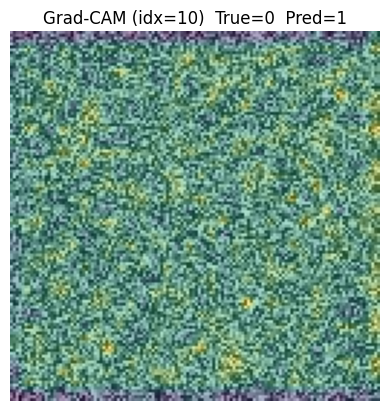

In [16]:
def get_last_conv_layer(model):
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    return None

def grad_cam(model, img_array, layer_name, upsample_size):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(conv_outputs, pooled_grads), axis=-1).numpy()
    heatmap = np.maximum(heatmap, 0)
    if heatmap.max() != 0:
        heatmap /= heatmap.max()
    heatmap = tf.image.resize(heatmap[..., np.newaxis], upsample_size).numpy().squeeze()
    return heatmap

last_conv = get_last_conv_layer(improved_model)
print("Using last conv layer for Grad-CAM:", last_conv)

num_samples = min(6, X_test.shape[0])
idxs = np.random.choice(np.arange(X_test.shape[0]), size=num_samples, replace=False)

for idx in idxs:
    img = X_test[idx:idx+1]
    heatmap = grad_cam(improved_model, img, last_conv, upsample_size=img.shape[1:3])
    plt.figure()
    plt.imshow(img[0].squeeze(), cmap='gray')
    plt.imshow(heatmap, alpha=0.4)
    plt.title(f'Grad-CAM (idx={idx})  True={int(y_test[idx])}  Pred={int((improved_model.predict(img).ravel()[0] >= 0.5))}')
    plt.axis('off')
    plt.show()

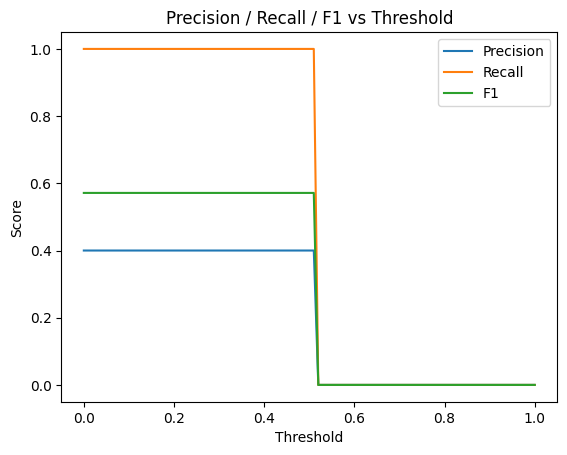

In [17]:
thresholds = np.linspace(0, 1, 101)
precisions, recalls, f1s = [], [], []
from sklearn.metrics import precision_score, recall_score, f1_score
for th in thresholds:
    p = (test_preds_proba >= th).astype(int)
    precisions.append(precision_score(y_test, p, zero_division=0))
    recalls.append(recall_score(y_test, p, zero_division=0))
    f1s.append(f1_score(y_test, p, zero_division=0))

plt.figure()
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1s, label='F1')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision / Recall / F1 vs Threshold')
plt.legend()
plt.show()